In [1]:
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
import os
import tempfile
import numpy as np
import pandas as pd
import csv
import string
import json
import tensorflow as tf
import pickle
import copy

from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt

## Analysis of skills using word2vec embedding

In [2]:
fpath= os.getcwd()
fprepath= os.path.join(fpath,"Preprocessing/")
file = open(os.path.join(fprepath,"JobSentenceEmb.p"),"rb")
# file = open(os.path.join(fprepath,"jobSkillD2V_sep.p"),"rb")
JobSentenceEmb = pickle.load(file)

In [5]:
JobSentenceEmb[0][2]

[['15',
  'years',
  'qualified',
  'leadership',
  'experience',
  'project',
  'management',
  'quality',
  'assurance',
  'qa',
  'configuration',
  'management',
  'requirements',
  'analysis',
  'testing',
  'evaluation'],
 ['led',
  'integrated',
  'software',
  'hardware',
  'test',
  'teams',
  'multiple',
  'projects'],
 ['conducted',
  'qa/audits',
  'highly',
  'regulated',
  'industries',
  'adhering',
  'food',
  'drug',
  'administration',
  'regulations',
  'iso',
  '9001'],
 ['extensive',
  'experience',
  'automated',
  'installation',
  'entry',
  'system',
  'aie',
  'integrated',
  'commercial',
  'intrusion',
  'detection',
  'system',
  'icids',
  'bio-tech',
  'medical',
  'equipment',
  'enterprise',
  'system',
  'website',
  'testing',
  'applications',
  'graphic',
  'user',
  'interface',
  'gui'],
 ['participated', 'system', 'design', 'architecture', 'review'],
 ['areas',
  'expertise',
  'full',
  'range',
  'qa',
  'concepts',
  'project',
  'management',

In [6]:
pmSentences= []
for jse in JobSentenceEmb:
    if jse[0].find("project manager or equivalent")!= -1 and jse[0].find("senior project manager or equivalent")== -1:
        pmSentences.append(jse[0:4])

jsenemb=[]
jsenskill=[]
for js in pmSentences:
    for tkn in js[3]:
        jsenemb.append(tkn)  
    for tk in js[2]:
        jsenskill.append(tk)

print ('Total Sentences: {}'.format(len(jsenemb)))

Total Sentences: 1501


Metric: cosine
Eps: 0.64
Min Samples: 2
Estimated number of clusters: 75
Estimated number of noise points: 606
76


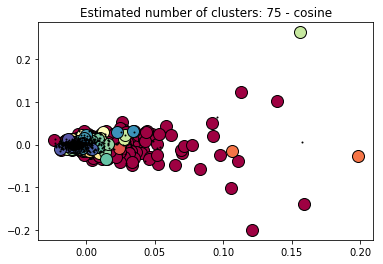

In [7]:
minSamples=[2]
eps = [0.64]

jsenemb = np.asarray(jsenemb)
mets = ['cosine']#,'canberra','hamming']#'euclidean'#'cosine'
# #############################################################################
# Compute DBSCAN
for met in mets:
    print('Metric: %s' %met)
    for ep in eps:
        print('Eps: {}'.format(ep))
        for minsample in minSamples:
            dbscan_model = DBSCAN(eps=ep, min_samples=minsample,metric=met)
            x = dbscan_model.fit(jsenemb)
            core_samples_mask = np.zeros_like(dbscan_model.labels_, dtype=bool)
            core_samples_mask[dbscan_model.core_sample_indices_] = True
            labels = dbscan_model.labels_

        # Number of clusters in labels, ignoring noise if present.
            n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
            n_noise_ = list(labels).count(-1)

            print('Min Samples: {}'.format(minsample))
            print('Estimated number of clusters: %d' % n_clusters_)
            print('Estimated number of noise points: %d' % n_noise_)
            
            #Calculation of Principal Component analysis
            pca = PCA(n_components=2).fit(jsenemb)
            datapoint = pca.transform(jsenemb)

            # Plot result
            # Black removed and is used for noise instead.
            unique_labels = set(labels)
            colors = [plt.cm.Spectral(each)
                      for each in np.linspace(0, 1, len(unique_labels))]
            print(len(colors))
            for k, col in zip(unique_labels, colors):
                if k == -1:
                    # Black used for noise.
                    col = [0, 0, 0, 1]

                class_member_mask = (labels == k)

                xy = datapoint[class_member_mask & core_samples_mask]
                plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
                         markeredgecolor='k', markersize=12)

                xy = datapoint[class_member_mask & ~core_samples_mask]
                plt.plot(xy[:, 0], xy[:, 1], '.', markerfacecolor=tuple(col),
                         markeredgecolor='k', markersize=2)

#             plt.margins(x=0, y=-0.45)   # Values in (-0.5, 0.0) zooms in to center

            plt.title('Estimated number of clusters: {} - {}'.format(n_clusters_,met))
            plt.show()

In [30]:
#Print lables and skills
len(labels)
for l in range(len(labels)):
    print("{}*{}*{}".format(l,jsenskill[l],labels[l]))

0*['15', 'years', 'qualified', 'leadership', 'experience', 'project', 'management', 'quality', 'assurance', 'qa', 'configuration', 'management', 'requirements', 'analysis', 'testing', 'evaluation']*0
1*['led', 'integrated', 'software', 'hardware', 'test', 'teams', 'multiple', 'projects']*-1
2*['conducted', 'qa/audits', 'highly', 'regulated', 'industries', 'adhering', 'food', 'drug', 'administration', 'regulations', 'iso', '9001']*-1
3*['extensive', 'experience', 'automated', 'installation', 'entry', 'system', 'aie', 'integrated', 'commercial', 'intrusion', 'detection', 'system', 'icids', 'bio-tech', 'medical', 'equipment', 'enterprise', 'system', 'website', 'testing', 'applications', 'graphic', 'user', 'interface', 'gui']*-1
4*['participated', 'system', 'design', 'architecture', 'review']*-1
5*['areas', 'expertise', 'full', 'range', 'qa', 'concepts', 'project', 'management', 'scope', 'management', 'time', 'management', 'site', 'management', 'fielding', 'risk', 'management', 'communicat

# Analysis kills using Doc2Vec embedding

In [8]:
fpath= os.getcwd()
fprepath= os.path.join(fpath,"Preprocessing/")
file = open(os.path.join(fprepath,"jobSenD2V.p"),"rb")
JobSentenceEmb = pickle.load(file)

In [9]:
pmSentences= []
for jse in JobSentenceEmb:
    if jse[0].find("project manager or equivalent")!= -1 and jse[0].find("senior project manager or equivalent")== -1:
        pmSentences.append(jse[0:4])

jsenemb=[]
jsenskill=[]
for js in pmSentences:
    for tkn in js[3]:
        jsenemb.append(tkn)  
    for tk in js[2]:
        jsenskill.append(tk)

print ('Total Sentences: {}'.format(len(jsenemb)))

Total Sentences: 1501


Metric: canberra
Eps: 7
Min Samples: 2
Estimated number of clusters: 18
Estimated number of noise points: 1463
19


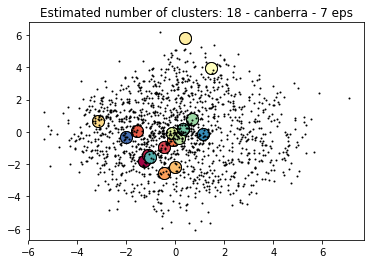

In [48]:
minSamples=[2]
eps = [7]#[0.2,0.25,0.266]- canberra 8, euclidean 6.6 , cosine .266

jsenemb = np.asarray(jsenemb)
mets = ['canberra']#,'canberra','hamming']#'euclidean'#'cosine'
# #############################################################################
# Compute DBSCAN
for met in mets:
    print('Metric: %s' %met)
    for ep in eps:
        print('Eps: {}'.format(ep))
        for minsample in minSamples:
            dbscan_model = DBSCAN(eps=ep, min_samples=minsample,metric=met)
            x = dbscan_model.fit(jsenemb)
            core_samples_mask = np.zeros_like(dbscan_model.labels_, dtype=bool)
            core_samples_mask[dbscan_model.core_sample_indices_] = True
            labels = dbscan_model.labels_

        # Number of clusters in labels, ignoring noise if present.
            n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
            n_noise_ = list(labels).count(-1)

            print('Min Samples: {}'.format(minsample))
            print('Estimated number of clusters: %d' % n_clusters_)
            print('Estimated number of noise points: %d' % n_noise_)
            
            #Calculation of Principal Component analysis
            pca = PCA(n_components=2).fit(jsenemb)
            datapoint = pca.transform(jsenemb)

            # Plot result
            # Black removed and is used for noise instead.
            unique_labels = set(labels)
            colors = [plt.cm.Spectral(each)
                      for each in np.linspace(0, 1, len(unique_labels))]
            print(len(colors))
            for k, col in zip(unique_labels, colors):
                if k == -1:
                    # Black used for noise.
                    col = [0, 0, 0, 1]

                class_member_mask = (labels == k)

                xy = datapoint[class_member_mask & core_samples_mask]
                plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
                         markeredgecolor='k', markersize=12)

                xy = datapoint[class_member_mask & ~core_samples_mask]
                plt.plot(xy[:, 0], xy[:, 1], '.', markerfacecolor=tuple(col),
                         markeredgecolor='k', markersize=2)

#             plt.margins(x=0, y=-0.45)   # Values in (-0.5, 0.0) zooms in to center

            plt.title('Estimated number of clusters: {} - {} - {} eps'.format(n_clusters_,met, ep))
            plt.show()